## Legend for the notebook
Find answers to all the questions at the last, as well as reasoning in the places where required.
Have tried to provide all necessary comments.
Code written by: Dhruv Amit Kulkarni

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Fraud.csv')


### Let's perform some exploratory data analysis




In [ ]:
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


In [ ]:
df.shape

(6362620, 11)

In [ ]:
df.isnull().sum()

,0
step,0
type,0
amount,0
nameOrig,0
oldbalanceOrg,0
newbalanceOrig,0
nameDest,0
oldbalanceDest,0
newbalanceDest,0
isFraud,0


In [ ]:
df['isFraud'].value_counts()

,count
isFraud,
0,6354407
1,8213


### We see here that the target variable is highly imbalanced!!

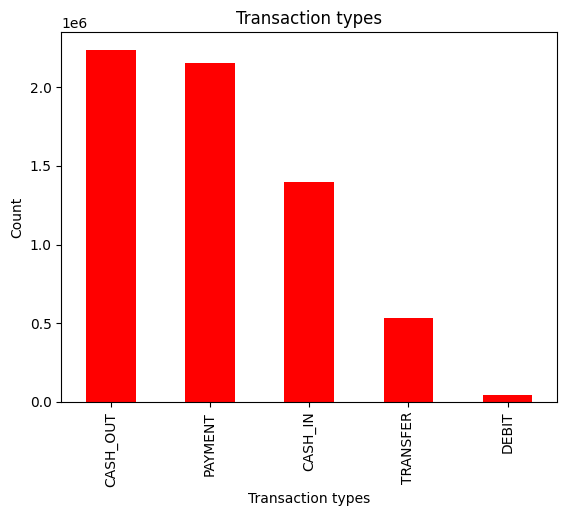

In [ ]:
df["type"].value_counts().plot(kind="bar",title='Transaction types',color='red')
plt.xlabel("Transaction types")
plt.ylabel("Count")
plt.show()

Let's check whether there is any connection between fraud and amount of transaction.

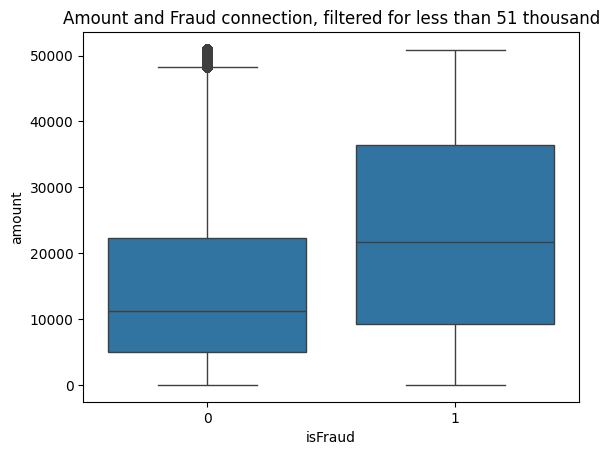

In [ ]:
sns.boxplot(data=df[df["amount"]<51000],x="isFraud",y="amount")
plt.title("Amount and Fraud connection, filtered for less than 51 thousand")
plt.show()

### Important observation: Frauds Increase if amount increases!

We see that we have to implement a classifier, so the ML model we use has to be Logistic regression.


In [ ]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report,confusion_matrix

Now comes the point to decide what features will be needed.
We will not use unecessary features, such as names of Origin or names of destination, as well as what the flagged result was.

In [ ]:
df_for_model=df.drop(["nameOrig","nameDest","isFlaggedFraud"],axis=1)

In [ ]:
df_for_model.head(5)

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0


In [ ]:
categorical_ones=['type']
numeric_ones=['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']

In [ ]:
y=df_for_model['isFraud']
X=df_for_model.drop('isFraud',axis=1)


In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,stratify=y)

In [ ]:
preprocessor=ColumnTransformer(
    transformers=[("num",StandardScaler(),numeric_ones),
    ("cat",OneHotEncoder(drop="first"),categorical_ones)],remainder="drop"
)

In [ ]:
pipeline=Pipeline([("prep",preprocessor),("clf",LogisticRegression(class_weight="balanced",max_iter=1000))])

In [ ]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['amount', 'oldbalanceOrg',
                                                   'newbalanceOrig',
                                                   'oldbalanceDest',
                                                   'newbalanceDest']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['type'])])),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [ ]:
y_pred=pipeline.predict(X_test)

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97   1906322
           1       0.02      0.94      0.04      2464

    accuracy                           0.95   1908786
   macro avg       0.51      0.94      0.51   1908786
weighted avg       1.00      0.95      0.97   1908786



In [ ]:
confusion_matrix(y_test,y_pred)

array([[1806090,  100232],
       [    146,    2318]])

## Answers to the questions asked

**Q1. Data cleaning including missing values, outliers and multi-collinearity.**  
Ans. Answered using necessary preprocessor, and EDA – Exploratory Data Analysis.  

**Q2. Describe your fraud detection model in detail**  
Ans. This is a classification task, so I thought best to use a logistic regression model. A logistic regression model is defined as:  
&nbsp;&nbsp;&nbsp;&nbsp;_y = 1 / (1 + e<sup>−x</sup>)_,  
so that the prediction works best. Logistic regression is interpretable (we can understand insights) as well as lightweight(not very compute heavy) In reality, a lot of preprocessing was required, since some features were categorical and others were numerical.  
It was necessary to use appropriate preprocessing pipelines.  

**Q3. How did you select variables to be included in the model?**  
Ans. Non-essential name-based variables were dropped, considering they don't provide meaningful mathematical context to the model.  
<<<< Written by Dhruv Amit Kulkarni >>>>
**Q4. Demonstrate model performance**  
Ans. Model performance was demonstrated using **accuracy**, **F1-score**, **recall**, and **precision** as metrics. About **95% accuracy** was achieved.  

**Q5. What are the key factors that predict fraudulent behavior?**  
Ans. Category of transaction, amount of transaction are some key factors that stood out.  

**Q6. Do these factors make sense? If yes, how?**  
Ans. Yes, they do make sense, since they reflect real-world behavior. For example:  
Larger the transaction, larger the risk of fraud. And risk is also amplified when cash is sent out.

**Q7. Precaution recommended**  
Ans. Maintain special watch on large and outgoing transactions. A **key verification system** could also help.  

**Q8. How to determine if precautions work?**  
Ans. Simulate attacks with dummy malicious users. If the system correctly detects frauds in these scenarios, that validates the precautions.
